# A/B Testing: e-Commerce Websites 


In this notebook we'll assess the results from an A/B test. We will use the dataset from Kaggle ("ab_test.csv"), which contrains the results from an A/B test on conversion rates from using a new vs. old landing page design.

Here is how we will approach this problem: 

1. [Context](#1.-Context)
2. [Formulate a hypothesis](#2.-Formulate-a-hypothesis)
3. [Preapre the dataset](#3.-Preapre-the-dataset )
4. [Determine the sample size](#4.-Determine-the-sample-size)
5. [Analyze the A/B test results](#5.-Analyze-the-A/B-test-results)
6. [Draw conclusions](#6.-Draw-conclusions)


## 1. Context

The e-commerce company has **developed a new version of the landing page website**, in hopes to **increase the conversion rate** of its customers (users who decided to purchase the company's product). The team has run an A/B test to compare the results of the new landing page to the original one. 

After discussing with product manager and business stakeholders, we learned that **the average coversion rate is 12%** throughout the year, and **minimal detectable effect** (the minimum difference / enhancement needed to consider launching the new page to production) is **2%**. This means that the new desgin will be considered successful if it can increase the conversion rate to 14%. 


## 2. Formulate a hypothesis 

Our null hypothesis is that the new design (treatment group) will be no different from the original design (control group). We are not sure yet whether the new design will increase or decrease conversion rate comparing to the old design. The alternative hypothesis is that the new design will be different from the old design. 
$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

where $p$ and $p_0$ stands for the conversation rate of the new and old design respectively.

Let's also set the confidence level to be 95%. 
$$\alpha = 0.05$$
In subsequent sections, we will clean the dataset and use the hypothesis testing to see if we can reject the null hypothesis. 

## 3. Preapre the dataset 

In [1]:
# Packages imports
import numpy as np #linear algebra
import pandas as pd #CSV file processsing 

import scipy.stats as stats 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from math import ceil

from IPython.display import display, Math

%matplotlib inline

In [2]:
#load the csv file top 5 rows
df = pd.read_csv("ab_test.csv") 
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [65]:
#rename the columns that so that makes more sense
df = df.rename(columns={'id':"user_id", "time":"timestamp", "con_treat":"group"})
df.head()

,user_id,timestamp,group,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [66]:
#general information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  int64 
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


This indicates that there are no null values amongst in the 29,4478 entries in total. 


Next we'd like to check if the number of samples in each group is equal. In an A/B test, ideally the same number of samples should be assigned to each group. 

In this test, we have two groups, one control group who is seeing the old landing page, and one treatment group who is seeing the new landing page. 

In [67]:
control_n = df[df['group']=='control'].shape[0]
treatment_n = df[df['group']=='treatment'].shape[0]
print(f'the control group has {control_n} observations whereas the treatment group has {treatment_n} observations. The difference is {abs(control_n-treatment_n)}.')

the control group has 147202 observations whereas the treatment group has 147276 observations. The difference is 74.


Since there is a sample ratio mismatch (we designed the A/B test to be 50/50 split, and assumed the two samples are idenpendent), we need to conduct **the Chi-Squared test of independence** to determine whether this mismatch is statistically significant. This test can indicate the probability of the two samples given, are independent. 

Conventionlly, we look for a p-value of 0.05 or less to determine indenpendence (which is the proof of sample ratio mismatch). 

In [68]:
observed_n = [control_n,treatment_n] 
total_observed = control_n+treatment_n
expected = [total_observed/2, total_observed/2] #we ideally have a 1:1 ratio between the groups

#import chisaqure test package
from scipy.stats import chisquare 

#calculates the p-value of the chi-square test 
chi = chisquare(observed_n, f_exp=expected) 
print(chi)

Power_divergenceResult(statistic=0.018595616650479832, pvalue=0.8915321515063552)


In [69]:
#we use the p-value threshold of 0.01 which is more strict than using 0.05
if chi[1]<0.01: 
    print("Sample ratio mismatch may be present. Data could be invalid.")
else: 
    print("No significant sample ratio mismatch detected. We may proceed with the analysis.")

No significant sample ratio mismatch detected. We may proceed with the analysis.


The above chi-squred test tells us that although there is a difference between the number of samples in each group, **the sample ratio mismatch is not significant**. Therefore we now proceed preparing the dataset.

Next, since the design of the experiment is that users of the control group should land on the old page, and users of the treatment group should land on the new page, we'd like to do a quick sanity check to see if the assignment is true in the test results. 

In [70]:
# pulling the sessions when control group were landed on the new page and vice versa. 

df[((df["group"]=="treatment")&(df["page"]=='old_page'))|((df["group"]=="control")&(df["page"]=='new_page')) ]

,user_id,timestamp,group,page,converted
22,767017,58:15.0,control,new_page,0
240,733976,11:16.4,control,new_page,0
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
...,...,...,...,...,...
294014,813406,25:33.2,treatment,old_page,0
294200,928506,32:10.5,control,new_page,0
294252,892498,11:10.5,treatment,old_page,0
294253,886135,49:20.5,control,new_page,0


The above 3893 sessions indicates problems during the execution of the A/B test. There were 3893 users wrongly assigned to a different landing page. Since this percentage of the total number of sessions is low, we can remove the mismatched users from the dataset. 

In [71]:
df_mismatched = df[((df["group"]=="treatment")&(df["page"]=='old_page'))|((df["group"]=="control")&(df["page"]=='new_page'))]
df_new = df[~df['user_id'].isin(df_mismatched['user_id'])]
print(f'The updated dataset now has {df_new.shape[0]} entries')

The updated dataset now has 286692 entries


In [72]:
print(f'The upated dataset now has {df_new.user_id.nunique()} unique users')

The upated dataset now has 286691 unique users


In [73]:
print(f'The updated dataset has {len(df_new)-df_new.user_id.nunique()} duplicated row')

The updated dataset has 1 duplicated row


In [74]:
session_counts = df_new['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1]
print(f'The updated dataset has {multi_users.shape[0]} user(s) that has (have) duplicated sessions')
print(multi_users)

The updated dataset has 1 user(s) that has (have) duplicated sessions
773192    2
Name: user_id, dtype: int64


In [75]:
#drop the duplicated row 
df_new= df_new[~df_new['user_id'].isin(multi_users.index)]

In [76]:
print(f'The upated dataset now has {df_new.user_id.nunique()} unique users')

The upated dataset now has 286690 unique users


In [77]:
print(f'The updated dataset has {len(df_new)-df_new.user_id.nunique()} duplicated row')

The updated dataset has 0 duplicated row


Now that we know how many unique users there are in this A/B test, we would like to check how many respectively for the control and treatment group. We'd like to see if the number of samples per group is roughly the same.

In [78]:
# Does the control and treatment groups have the same number of samples? 
df_new.groupby("group")[["user_id"]].nunique()

,user_id
group,
control,143293
treatment,143397


Great! The numbers are roughtly the sampe. And as we tested before, the sample ratio mismatch is not significant. We may proceed to the next step, which is determining the sample size for the test. 


## 4. Determine the Sample Size


To determine the effective sample size, we need to consider the following factors: 

1) **Power of the test** ($1 - \beta$) - Power is the probability of making a correct decision (to reject the null hypothesis) when the null hypothesis is false. $\beta$ is usually set at 0.2 as a convention and consequently power is set to 0.8. 

2) **Alpha value** ($\alpha$) - $\alpha$ is the statistical significance, which we set to 0.05.

3) **Minimum Detectable Effect** - This is the practical siginificance boundary - we set this value to 2% according to the context earlier, this is the minimal change that matters from a business perspective to launch the new page. We hope to raise the conversion rate from 12% to 14%. 

In [53]:
#calculate sample size needed for each group, given the factors determined above
sample_size = sms.NormalIndPower().solve_power(
                sms.proportion_effectsize(0.12,0.14),
                power=0.8, alpha=0.05, ratio=1)

#round up to nearest integer 
sample_size = ceil(sample_size)

print(f'Need at least {sample_size} samples for each group.')

Need at least 4433 samples for each group.


### Random Sampling

With our dataset cleaned and sample size determined, we may proceeed to sample `4433` entries for each of the groups. 

In [54]:
control_sample = df_new[df_new['group']=='control'].sample(n=sample_size, random_state=10)
treatment_sample = df_new[df_new['group']=='treatment'].sample(n=sample_size, random_state=10)

df_abtest=pd.concat([control_sample,treatment_sample], axis=0)
df_abtest.reset_index(drop=True,inplace=True)

print(df_abtest)

      user_id timestamp      group      page  converted
0      691351   04:48.6    control  old_page          0
1      782396   06:22.7    control  old_page          0
2      802583   26:41.0    control  old_page          0
3      826544   32:30.1    control  old_page          0
4      786577   22:59.4    control  old_page          0
...       ...       ...        ...       ...        ...
8861   670145   04:29.7  treatment  new_page          0
8862   871192   48:10.8  treatment  new_page          0
8863   928303   05:12.6  treatment  new_page          0
8864   941717   28:04.7  treatment  new_page          0
8865   680467   31:34.4  treatment  new_page          0

[8866 rows x 5 columns]


In [55]:
df_abtest.groupby("group")[["user_id"]].nunique()

,user_id
group,
control,4433
treatment,4433


In [56]:
df_abtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    8866 non-null   int64 
 1   timestamp  8866 non-null   object
 2   group      8866 non-null   object
 3   page       8866 non-null   object
 4   converted  8866 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 346.5+ KB


Now the A/B test samples look good to go. Number of samples matches in each group and there is no missing/duplicate value. 

## 5. Analyze the A/B test results

### Bootstrapping

Now that we know the effective sample size for each group, we can use **bootstrapping** to assess the A/B testing results. The bootstrapping method takes the sample data, and then resamples it over and over to create many simulated samples. The idea of bootstrapping is that inferences about the population from sample data can be modelled by **resampling** the sample data and performing hypothesis tests on the resampled data. Then the procedure uses the sampling distribution as the foundation for confidence intervals and hypothesis testing. This information on bootstrapping is retrieved from https://statisticsbyjim.com/hypothesis-testing/bootstrapping/


In [57]:
bootstrap_conversion=[] #create a list with bootstrapped means

for i in range(500): #create 500 samples of dataset - bootstrapping 
   
    bootstrap_mean = df_abtest.sample(frac=1, replace=True).groupby('group')['converted'].mean()
 
    bootstrap_conversion.append(bootstrap_mean)


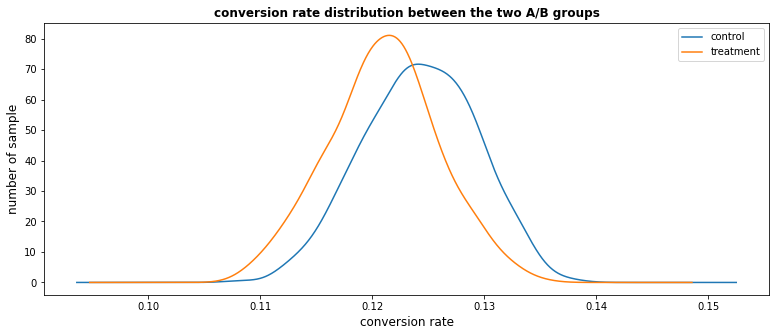

In [58]:
bootstrap_conversion = pd.DataFrame(bootstrap_conversion)

#plot the sampling distribution of the two a/b groups 
fig, (ax1) = plt.subplots(1, 1, figsize=(13,5))

bootstrap_conversion.plot.kde(ax=ax1)
ax1.set_xlabel("conversion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("conversion rate distribution between the two A/B groups", fontweight="bold",size=12)
plt.legend()
plt.show()

The above bootstrapping analysis appear to indicate that the new design (treatment group) did not perform better than the old design (control group). We'd like to explore further by using the **z-test** to see if the **p-value** is greater than the **alpha value** ($\alpha$). Since the simple size is very large, we can use the normal approximation. 

In [59]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [62]:
#converted counts of each group
control_converted = df_abtest[(df_abtest['converted']==1)&(df_abtest['page']=='old_page')]['user_id'].nunique()
treatment_converted = df_abtest[(df_abtest['converted']==1)&(df_abtest['page']=='new_page')]['user_id'].nunique()

#total sample size of each group
control_n = df_abtest[df_abtest['page']=='old_page']['user_id'].nunique()
treatment_n = df_abtest[df_abtest['page']=='new_page']['user_id'].nunique()

#transform into array
converts = [control_converted,treatment_converted]
observations = [control_n, treatment_n]

#calcualte the z score and p-value 
z_stat, p_value = proportions_ztest(count=converts,nobs=observations)

#confidence interval of the control & treatment group
(lower_c, lower_t), (upper_c, upper_t) = proportion_confint(count = converts,nobs= observations, alpha=0.05)


print(f'z statistic is {z_stat:.3f}')
print(f'p value is {p_value:.3f}')
print(f'95% confidence interval for control group is [{lower_c:.3f},{upper_c:.3f}]')
print(f'95% confidence interval for treatment group is [{lower_t:.3f},{upper_t:.3f}]')

z statistic is 0.454
p value is 0.650
95% confidence interval for control group is [0.114,0.134]
95% confidence interval for treatment group is [0.111,0.131]


## 6. Draw Conclusions

* **In terms of statistical significance: **

Since the p-value is way above the alpha value $\alpha$ of 0.05, we cannot reject the null hypothesis. This means that **the new design did not have a significant impact to conversion rates**, let alone improving conversion based on the old design..

* **In terms of practical significance:** 

The confidence interval for the treatment group [0.111,0.131] includes the baseline value of 12% conversion rate. However it **does not include the 14% mark** (resulted from the minimal detectable effect of a 2% increase that the stakeholders hoped to see). Therefore it reinfornces our conclusion that this new design does not appear to improve the conversion. 

**Weighing the costs & benefits, we do NOT reccommend launching this new page into production. **We hope to have more iterations that drives siginifant business impact in the near future!



### Additional considerations & suggestions: 

**1. Choosing the right metrics ** 

In this project, the A/B test is designed to measure the impact of a new landing page design to conversion rate (the percentage of users that ultimately purchased the product). While the conversion rate is a key goal metric for the business' overall success, **it is a transactional metric that is too far down in the customer's sales funnel, comparing to users' visits to the landing page.** 

As a result, one potential cause of the lack of significance could be the choice of our a/b testing goals and the respective metrics. Therefore we recommend further explore the steps along the user journey, to better understand what metrics best measure the success of the next new design of the landing page. 

For example, ** user engagement metrics can measure the success of the landing page more directly.** Metrics such as user session duration, clicks into product detail page or percentage of added-to-cart. These metrics narrows down the numerator of the metric of interest and tells a better story of how a landing page UI design performs. 

** 2. Executing the A/B test ** 

**Randomization**: In this project, we noticed that a number of unique users were wrongly assigned to landing pages different from that of their designated test group, or went through multiple sessions. Although the number is very small, we recommend investigating the A/B testing tool and fix potential bugs during the assignment/execution. 

**Sample ratio mismatch**: We also identified an insignificant sample ratio mismatch in this test. Although this time it was insignificant, we recommend examining and debugging the data processing pipeline, and close any gaps throughout the user's touchpoints. 

# Thank you for reading! Have a wonderful holiday break ahead! 

Below is the intructor's guidance for your reference :) 

In [61]:
# Not-exhaustive project checklist
# Note: this is not a writing assignment, but you should still incorporate comments or headers throughout
# -- This will help others who review your work, but will also help you keep track of what you're doing
# -- Just think about what would help you understand a peer's project when you have to grade theirs later


# 1) Dataset included
# 1a) Dataset explained/documented when used
# 2) Analysis performed
# 2a) Analysis steps documented, explained briefly
# 3) Visualizations/outputs
# 4) Conclusion
# ---Did you answer your questions?
# ---Did you find anything else?
# ---What problems did you run into?
# ---Any suggestions for future research?

# Critical checks before submission
# - Does the noteboook run without error? (Kernel>restart & run all => no errors at all? No long periods of processing?)
# - Do you have your dataset included here? You shouldn't be connecting to any external data
# - - Even if external datasets work here, they WILL NOT work for peer-grading, and you may get a 0.